<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name :MohammadMehdi Zare 
### Student Number : 98100431 
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [16]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################
import copy

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [18]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data
np.random.seed(11)

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


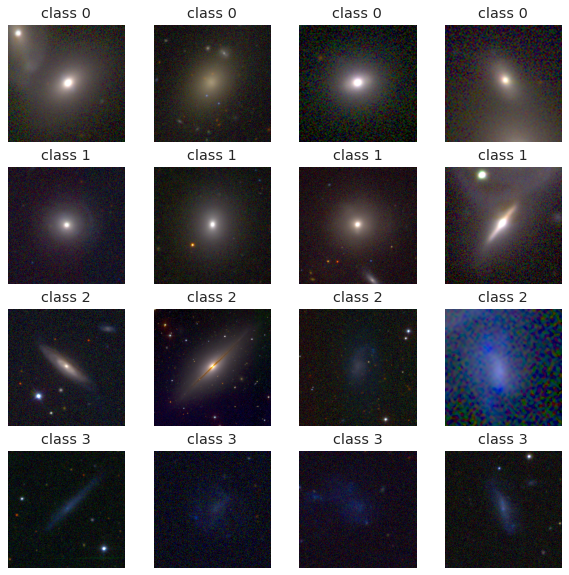

In [19]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################

fig = plt.figure(figsize=(10,10))
for i in range(4):
  thisClass=df[df.class_label==i]
  nameList=list(thisClass["name"])
  for j in range(4):
        img_grid = fig.add_subplot(4, 4,i*4+j+1)
        img=plt.imread("./efigi-1.6/png/"+nameList[j]+".png")
        img_grid.imshow(img)
        img_grid.set_yticks([])
        img_grid.set_xticks([])
        img_grid.set_title("class "+ str(i))

# Define Dataset (20 Points)

In [20]:
from matplotlib.projections.geo import Transform
import cv2
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

class GalaxyDataSet(Dataset):
    def __init__(self , database , transform):
        self.database=database
        self.transform=transform
    def __len__(self):
        return len(self.database)
    def __getitem__(self, index):
        imagedata= self.database.iloc[index]
        img= cv2.imread("./efigi-1.6/png/"+imagedata[0]+".png")
        img= cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        return self.transform(img) , imagedata[2]

# Define Model (20 Points)

In [21]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
def linear_relu(dim_in , dim_out):
  return [nn.Linear(dim_in,dim_out), nn.ReLU(inplace=True)]

class ClassifierModel(nn.Module):
    def __init__(self, input_size, num_classes):
      super(ClassifierModel,self).__init__()
      self.classifier= nn.Sequential(
          *linear_relu(input_size, 256),
          # *linear_relu(256,256),
          nn.Linear(256,num_classes)
      )

    def forward(self, x):
        x=x.view(x.size()[0],-1)
        y=self.classifier(x)
        return y 

# Train Model (30 Points)

In [22]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function ant etc                                     ##
######################################################################

def train ( model, loader ,f_loss , optimizer, device):
  model.train()
  for i , (inputs, targets) in enumerate(loader):
    inputs= inputs.to(device)
    targets= targets.to(device)

    upstream= model(inputs)
    loss=f_loss(upstream , targets)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [23]:
from sklearn.model_selection import train_test_split
def saveModel():
    path = "./myFirstModel.pth"
    torch.save(model.state_dict(), path)

def val(model , loader , f_loss , device):
    with torch.no_grad():
        model.eval()
        N=0
        total_loss=0.0
        correct=0.0
        for i , (inputs , targets) in enumerate(loader):
            inputs= inputs.to(device)
            targets= targets.to(device)
            upstream= model(inputs)

            N += inputs.shape[0]

            total_loss += inputs.shape[0] * f_loss(upstream, targets).item()

            predicted_targets = upstream.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
        return total_loss/N, correct/N





train_Val_df , test_dataset= train_test_split(df, test_size=.3)
train_dataset , val_dataset=train_test_split(train_Val_df , test_size=.3)


train_dataset= GalaxyDataSet(train_dataset,transforms.ToTensor() )
val_dataset= GalaxyDataSet(val_dataset ,transforms.ToTensor())
test_dataset= GalaxyDataSet(test_dataset,transforms.ToTensor())

threads_n=10
batch_size=100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True , num_workers=threads_n)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False , num_workers=threads_n)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False , num_workers=threads_n)


model= ClassifierModel(255*255*3 , 4)
model.to(device)
optimizer= torch.optim.Adam(model.parameters())
f_loss= torch.nn.CrossEntropyLoss()

epochs_n=20
val_losses = []
val_accuracy = []
train_losses = []
train_accuracy = []
best_acc=0
best_model=None
for i in range(epochs_n):
    print("Epoch {}".format(i))
    train(model, train_loader, f_loss, optimizer, device)
    train_loss, train_acc = val(model, train_loader, f_loss, device)
    val_loss, val_acc = val(model, val_loader, f_loss, device)
    val_losses.append(val_loss)
    val_accuracy.append(val_acc)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    print(" Training : Loss : {:.4f}, Acc : {:.4f}".format(train_loss, train_acc))
    print(" Validation : Loss : {:.4f}, Acc : {:.4f}".format(val_loss, val_acc))
    if best_acc < val_acc: 
      saveModel()
      best_acc=val_acc
      print("model saved!!")




/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0
 Training : Loss : 1.0466, Acc : 0.7537
 Validation : Loss : 1.1409, Acc : 0.7297
model saved!!
Epoch 1
 Training : Loss : 0.7121, Acc : 0.7880
 Validation : Loss : 0.8347, Acc : 0.7457
model saved!!
Epoch 2
 Training : Loss : 0.5944, Acc : 0.8255
 Validation : Loss : 0.7609, Acc : 0.7393
Epoch 3
 Training : Loss : 0.4748, Acc : 0.8045
 Validation : Loss : 0.7330, Acc : 0.7265
Epoch 4
 Training : Loss : 0.4042, Acc : 0.8700
 Validation : Loss : 0.6909, Acc : 0.7468
model saved!!
Epoch 5
 Training : Loss : 0.4450, Acc : 0.9025
 Validation : Loss : 0.7341, Acc : 0.7350
Epoch 6
 Training : Loss : 0.2799, Acc : 0.9029
 Validation : Loss : 0.6739, Acc : 0.7436
Epoch 7
 Training : Loss : 0.2540, Acc : 0.9093
 Validation : Loss : 0.7233, Acc : 0.7276
Epoch 8
 Training : Loss : 0.2024, Acc : 0.9295
 Validation : Loss : 0.6352, Acc : 0.7618
model saved!!
Epoch 9
 Training : Loss : 0.1983, Acc : 0.9762
 Validation : Loss : 0.6366, Acc : 0.7521
Epoch 10
 Training : Loss : 0.1295, Acc : 0.

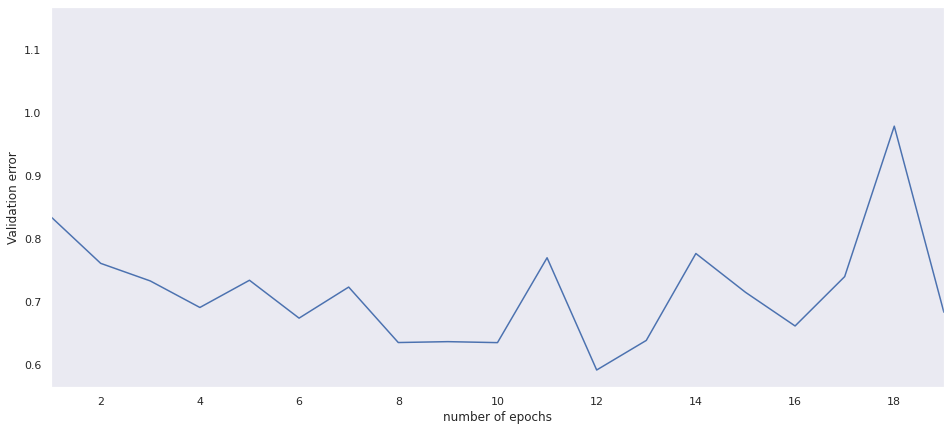

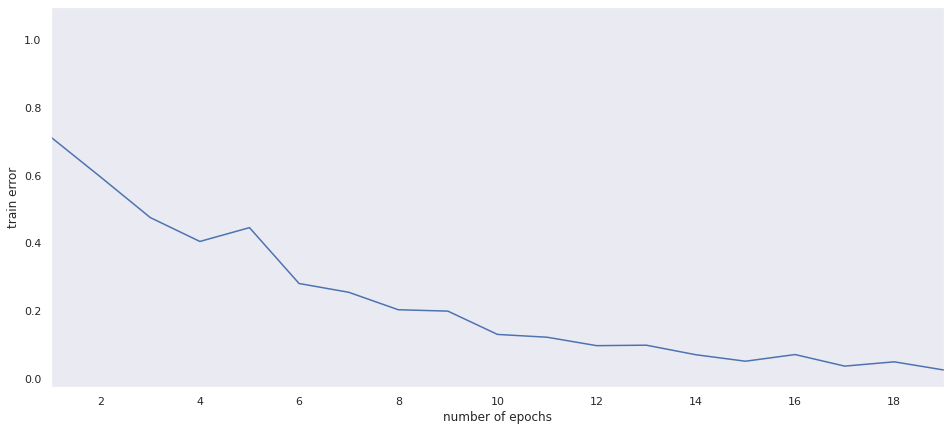

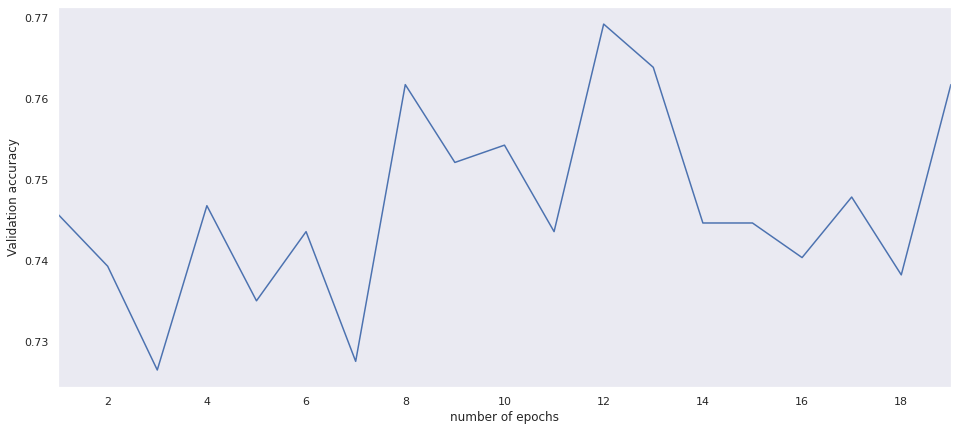

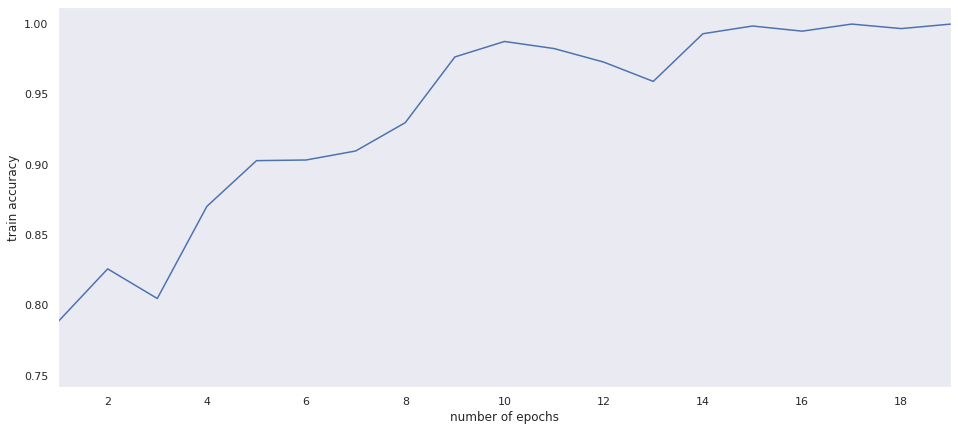

In [24]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
import seaborn as sns

plt.figure(figsize=(16, 7))
sns.set(style='dark',)
ax = sns.lineplot(x=list(range(epochs_n)), y=list(val_losses))
plt.xlabel("number of epochs")
plt.ylabel("Validation error")
ax.set_xlim([1, max(list(range(epochs_n)))])
plt.show()

plt.figure(figsize=(16, 7))
sns.set(style='dark',)
ax = sns.lineplot(x=list(range(epochs_n)), y=list(train_losses))
plt.xlabel("number of epochs")
plt.ylabel("train error")
ax.set_xlim([1, max(list(range(epochs_n)))])
plt.show()

plt.figure(figsize=(16, 7))
sns.set(style='dark',)
ax = sns.lineplot(x=list(range(epochs_n)), y=list(val_accuracy))
plt.xlabel("number of epochs")
plt.ylabel("Validation accuracy")
ax.set_xlim([1, max(list(range(epochs_n)))])
plt.show()

plt.figure(figsize=(16, 7))
sns.set(style='dark',)
ax = sns.lineplot(x=list(range(epochs_n)), y=list(train_accuracy))
plt.xlabel("number of epochs")
plt.ylabel("train accuracy")
ax.set_xlim([1, max(list(range(epochs_n)))])
plt.show()


# Test Model (20)

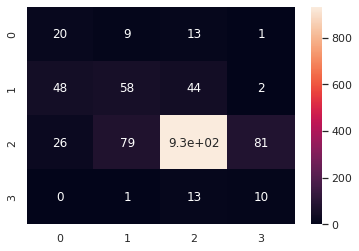

 Test       : Loss : 0.6104, Acc : 0.7631
Test: F1-score:  0.43219532243934666


In [27]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################
from sklearn.metrics import confusion_matrix
from scipy import stats as st
def update_confusion_matrix(conf_matrix, preds, reals):
    """
    Updates confusion matrix

    Args:
        conf_matrix : input confusion matrix
        preds : array of predicted labels
        reals : array of real labels

    Returns:
        conf_matrix : updated confusion matrix
    """
    for i in range(len(preds)):
        conf_matrix [preds[i]][reals[i]]+=1
    #################################
    ##          Your Code          ##
    #################################
    return conf_matrix

def f1_score(confusion_matrix):
    """
    calculate macro f1 score from given confusion matrix

    Args:
        confusion_matrix : given confusion matrix
        
    Returns:
        f1 : macro f1 score
    """
    
    rows_sum=np.sum(confusion_matrix,axis=1)
    cols_sum=np.sum(confusion_matrix,axis=0)
    prec_classes=confusion_matrix.diagonal()/rows_sum
    recal_classes=confusion_matrix.diagonal()/cols_sum
    f1_score =np.mean(2*((prec_classes*recal_classes)/(prec_classes+recal_classes)))
    
    #################################
    ##          Your Code          ##
    #################################
    return f1_score


def test(model , loader , f_loss , device):
    with torch.no_grad():
        model.eval()
        N=0
        total_loss=0
        correct=0
        y_pred=[]
        y_true=[]
        classes = ("Irregulars", "Spirals", "Ellipticals", "Lenticulars")
        confusion = np.zeros((4,4))
        for i , (inputs , targets) in enumerate(loader):
            inputs= inputs.to(device)
            targets= targets.to(device)
            upstream= model(inputs)
            total_loss += inputs.shape[0] * f_loss(upstream, targets).item()
            N += inputs.shape[0]
            predicted_targets = upstream.argmax(dim=1)
            correct += (predicted_targets == targets).sum().item()
            update_confusion_matrix(confusion , np.argmax(upstream.cpu().detach().numpy(),axis=1) ,targets.cpu().detach().numpy() )
            # y_pred.extend(predicted_targets.cpu().detach().numpy())
            # y_true.extend(targets.cpu().detach().numpy())

        
# Build confusion matrix
        sns.heatmap(confusion, annot=True)
        plt.show()
        return total_loss/N, correct/N , f1_score(confusion)



model=ClassifierModel(3*255*255, 4)
path = "myFirstModel.pth"
model = model.to(device)

model.load_state_dict(torch.load(path))
model.eval()

test_loss, test_acc, f1 = test(model, test_loader, f_loss, device)
print(" Test       : Loss : {:.4f}, Acc : {:.4f}".format(test_loss, test_acc))
print("Test: F1-score: ",f1)